## Function 

### function - short name

In [19]:
import re
from pathlib import Path

def make_short_name(path: Path, base_dir: Path) -> str:
    """
    Generate a compact name from a long UCM scenario file.

    Example:
    input:
        dir_ucm_out / "current_lulc" / "work_and_energy_runs" / "intermediate"
        / "T_air_london_scenario_20.0deg_2.0uhi_66.9hum_energy_productivity.tif"
    output:
        "current_lulc_20_2"
    """
    path = Path(path)

    # 1. Get the scenario prefix (folder immediately under base_dir)
    try:
        prefix = path.relative_to(base_dir).parts[0]
    except ValueError:
        raise ValueError(f"{path} is not inside {base_dir}")

    # 2. Extract the deg/uhi numbers from the filename
    m = re.search(r"scenario_([\d.]+)deg_([\d.]+)uhi", path.name)
    if not m:
        raise ValueError(f"Could not parse scenario from {path.name}")

    deg = str(int(float(m.group(1))))   # "20.0" -> "20"
    uhi = str(int(float(m.group(2))))   # "2.0"  -> "2"

    return f"{prefix}_{deg}_{uhi}"


# # Example usage
# from pathlib import Path

# wd_main     = Path(r"G:\Shared drives\Wellcome Trust Project Data") 
# dir_ucm_out = wd_main / "2_postprocess_intermediate" / "UCM_official_runs"

# f = dir_ucm_out / "current_lulc" / "work_and_energy_runs" / "intermediate" \
#     / "T_air_london_scenario_20.0deg_2.0uhi_66.9hum_energy_productivity.tif"

# print(make_short_name(f, dir_ucm_out))
# # -> current_lulc_20_2


### function - zonal stats

In [20]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
from rasterstats import zonal_stats

def run_zonal_stats(
    aoi_path,
    raster_path,
    model_output_path, 
    out_dir,
    stats=["mean"],
    nodata=-9999.0,
    suffix=None,
    drop_cols=None
):
    """
    Compute zonal statistics for a single raster and save results to CSV.

    Parameters
    ----------
    aoi_path : str or Path
        Path to AOI shapefile/GeoJSON/GeoPackage.
    raster_path : str or Path
        Path to raster file.
    out_dir : str or Path
        Directory where output CSV will be saved.
    stats : list[str], default ["mean"]
        Zonal statistics to compute.
    nodata : float, default -9999.0
        NoData value in raster.
    suffix : str or None
        Optional suffix to append to stat column names and output file.
        If None, uses raster file stem.
    drop_cols : list[str] or None
        Columns to drop from output DataFrame.

    Returns
    -------
    pd.DataFrame
        DataFrame with zonal statistics.
    """
    aoi = gpd.read_file(aoi_path)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    raster_path = Path(raster_path)
    suffix = make_short_name(raster_path, model_output_path)

    
    # look for folder names of interest
    candidates = ["lulc", "scenario"]
    lc_scenario = next((p for p in raster_path.parts if any(c in p for c in candidates)), None)
    print(lc_scenario)  # → "scenario1"

    # Run zonal stats
    zs_result = zonal_stats(
        aoi,
        str(raster_path),
        nodata=nodata,
        geojson_out=True,
        stats=stats
    )

    zs_gdf = gpd.GeoDataFrame.from_features(zs_result)
    df = pd.DataFrame(zs_gdf)

    # Add scenario/lc column if found
    if lc_scenario:
        df["lc_scenario"] = lc_scenario

    # add raster name column
    df["raster"] = raster_path.name

    # # Rename stats columns
    # rename_dict = {s: f"{s}_{suffix}" for s in stats}
    # df = df.rename(columns=rename_dict)

    

    # Drop unwanted columns
    if drop_cols:
        df = df.drop(columns=drop_cols, errors="ignore")

    # Save to CSV
    out_csv = out_dir / f"{suffix}_zonal_stats.csv"
    df.to_csv(out_csv, index=False)
    print(f"[OK] Zonal stats saved → {out_csv}")

    return df


## Data dir

In [21]:
from pathlib import Path

# Set the working directory
wd_main     = Path(r"G:\Shared drives\Wellcome Trust Project Data") 
wd_shp      = wd_main / "1_preprocess" / "UrbanCoolingModel" / "OfficialWorkingInputs" / "AOIs"
dir_ucm_out = wd_main / "2_postprocess_intermediate" / "UCM_official_runs"
dir_ucm_stat= dir_ucm_out / "ucm_output_postprocess"
figures_dir = wd_main / "3_final" / "UCM_figures"

## Batch temp raster 

In [22]:
aoi_adm = wd_shp / "London_Borough_aoi.shp"  # Administrative boundary (e.g., census tracts)

drop_cols = ["HECTARES", "NONLD_AREA", "ONS_INNER", "SUB_2009", "SUB_2006", "geometry"]


## loop more rasters

In [23]:

rasters = [
    ## s0
    dir_ucm_out / "current_lulc" / "work_and_energy_runs" / "intermediate" / "T_air_london_scenario_20.0deg_2.0uhi_66.9hum_energy_productivity.tif",
    dir_ucm_out / "current_lulc" / "work_and_energy_runs" / "intermediate" / "T_air_london_scenario_25.0deg_5.0uhi_45.0hum_energy_productivity.tif",

    # s1
    # dir_ucm_out / "scenario1"   / "work_and_energy_runs"  / "intermediate" / "T_air_london_scenario_20.0deg_2.0uhi_66.9hum_energy_productivity.tif",
    # dir_ucm_out / "scenario1"   / "work_and_energy_runs"  / "intermediate" / "T_air_london_scenario_25.0deg_5.0uhi_45.0hum_energy_productivity.tif",
    
    # s2
    dir_ucm_out / "scenario2"   / "work_and_energy_runs"  / "intermediate" / "T_air_london_scenario_20.0deg_2.0uhi_66.9hum_energy_productivity.tif",
    dir_ucm_out / "scenario2"   / "work_and_energy_runs"  / "intermediate" / "T_air_london_scenario_25.0deg_5.0uhi_45.0hum_energy_productivity.tif",

    # s3
    dir_ucm_out / "scenario3"   / "work_and_energy_runs"  / "intermediate" / "T_air_london_scenario_20.0deg_2.0uhi_66.9hum_energy_productivity.tif",
    dir_ucm_out / "scenario3"   / "work_and_energy_runs"  / "intermediate" / "T_air_london_scenario_25.0deg_5.0uhi_45.0hum_energy_productivity.tif",

    # s4
]


all_results = []
for raster in rasters:
    # out_dir = raster.parent
    df = run_zonal_stats(
        aoi_path=aoi_adm,
        raster_path=raster,
        model_output_path = dir_ucm_out,
        out_dir=dir_ucm_stat,
        stats=["mean"],
        drop_cols=drop_cols
    )
    all_results.append(df)

# # Optionally merge all results side-by-side
# df_combined = pd.concat(all_results, axis=1)
# print(df_combined.head())


# row-wise combine
df_combined = pd.concat(all_results, axis=0, ignore_index=True)


current_lulc
[OK] Zonal stats saved → G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UCM_official_runs\ucm_output_postprocess\current_lulc_20_2_zonal_stats.csv
current_lulc
[OK] Zonal stats saved → G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UCM_official_runs\ucm_output_postprocess\current_lulc_25_5_zonal_stats.csv
scenario2
[OK] Zonal stats saved → G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UCM_official_runs\ucm_output_postprocess\scenario2_20_2_zonal_stats.csv
scenario2
[OK] Zonal stats saved → G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UCM_official_runs\ucm_output_postprocess\scenario2_25_5_zonal_stats.csv
scenario3
[OK] Zonal stats saved → G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UCM_official_runs\ucm_output_postprocess\scenario3_20_2_zonal_stats.csv
scenario3
[OK] Zonal stats saved → G:\Shared drives\Wellcome Trust Project Data\2_postprocess

In [24]:


# Save to CSV
out_csv = dir_ucm_stat / f"T_air_london_{len(all_results)}_zonal_stats_long.csv"
df_combined.to_csv(out_csv, index=False)
print(f"[OK] Zonal stats saved → {out_csv}")

[OK] Zonal stats saved → G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UCM_official_runs\ucm_output_postprocess\T_air_london_6_zonal_stats_long.csv


## Plot

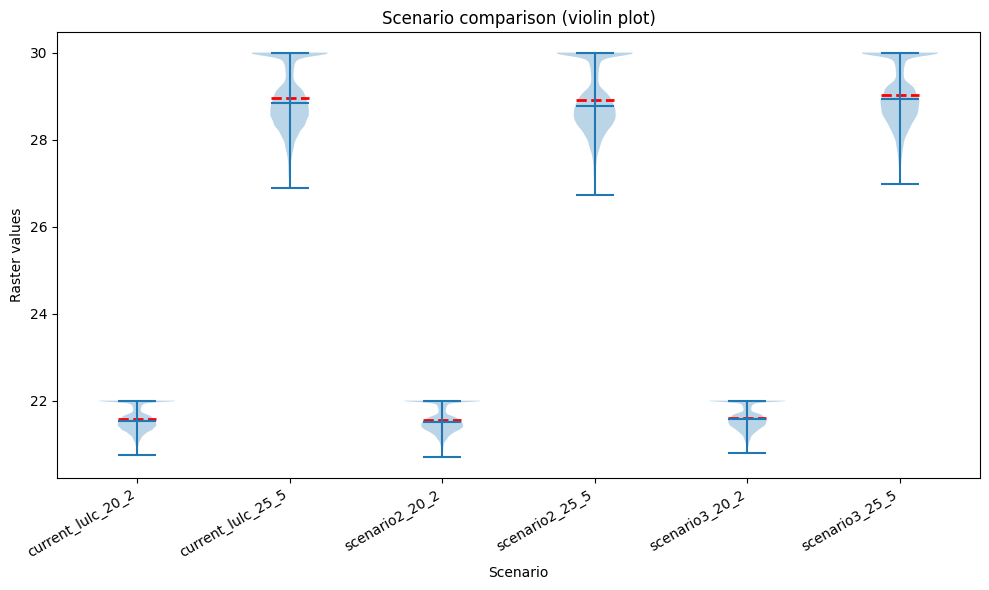

In [26]:
import re
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- helper to build compact label e.g. "current_lulc_20_2" ----------
def make_short_name(path: Path, base_dir: Path) -> str:
    path = Path(path)
    try:
        prefix = path.relative_to(base_dir).parts[0]  # e.g., current_lulc / scenario2 / scenario3
    except ValueError:
        prefix = path.parent.name  # fallback to immediate parent if path not under base_dir
    m = re.search(r"scenario_([\d.]+)deg_([\d.]+)uhi", path.name)
    if not m:
        return prefix
    deg = str(int(float(m.group(1))))
    uhi = str(int(float(m.group(2))))
    return f"{prefix}_{deg}_{uhi}"

# ---------- config ----------
# Put your 'dir_ucm_out' here if not already defined:
# from pathlib import Path
# wd_main     = Path(r"G:\Shared drives\Wellcome Trust Project Data") 
# dir_ucm_out = wd_main / "2_postprocess_intermediate" / "UCM_official_runs"


BASE_DIR = dir_ucm_out
MAX_SAMPLES_PER_RASTER = 200_000   # cap for speed/memory; raise/lower as you wish

# ---------- load values ----------
violin_data = []
labels = []

for rp in rasters:
    rp = Path(rp)
    if not rp.exists():
        print(f"[warn] missing raster: {rp}")
        continue

    with rasterio.open(rp) as src:
        arr = src.read(1)  # first band
        nodata = src.nodata

    # mask nodata / nan / inf
    arr = arr.astype("float64", copy=False)
    if nodata is not None:
        valid = (arr != nodata)
    else:
        valid = np.ones(arr.shape, dtype=bool)

    valid &= np.isfinite(arr)  # drop NaN, +inf, -inf
    vals = arr[valid].ravel()

    # optional subsample for performance
    if vals.size > MAX_SAMPLES_PER_RASTER:
        idx = np.random.default_rng(42).choice(vals.size, size=MAX_SAMPLES_PER_RASTER, replace=False)
        vals = vals[idx]

    if vals.size == 0:
        print(f"[warn] all values invalid after masking: {rp.name}")
        continue

    violin_data.append(vals)
    labels.append(make_short_name(rp, BASE_DIR))

# ---------- plot (matplotlib only; one figure; no custom colors) ----------
fig, ax = plt.subplots(figsize=(10, 6))

parts = ax.violinplot(
    violin_data,
    showmeans=True,
    showextrema=True,
    showmedians=True
)

# Style the parts
# Means are red dashed lines
if 'cmeans' in parts:
    parts['cmeans'].set_color('red')
    parts['cmeans'].set_linestyle('--')
    parts['cmeans'].set_linewidth(2)

# # Medians are blue solid lines
# if 'cmedians' in parts:
#     parts['cmedians'].set_color('blue')
#     parts['cmedians'].set_linewidth(2)

# X-axis labels
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=30, ha="right")

ax.set_xlabel("Scenario")
ax.set_ylabel("Raster values")
ax.set_title("Scenario comparison (violin plot)")

plt.tight_layout()
plt.show()
